In [2]:
import re
import numpy as np
import pandas as pd


In [6]:
import os
os.listdir("/Users/pavankumar/Downloads")



['IMG_1713.HEIC',
 'IMG_2095.HEIC',
 'IMG_2696.MOV',
 'IMG_7628.HEIC',
 'IMG_8027.HEIC',
 'IMG_1656.HEIC',
 'IMG_7501.heic',
 'IMG_5496.HEIC',
 '_DSC0835.JPG',
 'IMG_1590.HEIC',
 'mock-test-2-Pavan8765-1',
 'C7CF4E9A-6B67-4034-9C38-D817A317B60D.MP4',
 '_DSC0809.JPG',
 'IMG_1969.HEIC',
 'DEA_Solver_Project1_Setup.xlsx',
 'PPT1.pptx',
 'QEX383708684_auth_letter.pdf',
 '_DSC1040.JPG',
 'BEMM464',
 'IMG_1744.HEIC',
 'IMG_1601.HEIC',
 '0C246061-526C-40EF-BB8D-66199F44C6C3.MP4',
 'IMG_5462.MOV',
 'IMG_1528.HEIC',
 'Project- Generic Example..pdf',
 'IMG_6157.MOV',
 'IMG_1894.HEIC',
 'Aadhar card.pdf',
 'IMG_2241.HEIC',
 'Final New Venture Creation 2.docx',
 'D219D4E8-DEA7-4279-89A1-60CC19A23A0B.MP4',
 'IMG_1752.HEIC',
 'googlechrome.dmg',
 '53FA41FF-23BF-4205-AF23-AB34F35A9F70.JPG',
 'JANUARY.pages',
 'IMG_7498.MOV',
 'IMG_1617.HEIC',
 'IMG_5087.HEIC',
 'IMG_2742.HEIC',
 'IMG_2245.MOV',
 '058903_Xac94d503_1_318.docx',
 'IMG_7329.MOV',
 'IMG_1882.HEIC',
 'shashanktcs.pdf',
 'IMG_5068.HEIC',
 '

In [8]:
import os
os.listdir("/Users/pavankumar/Downloads/Dataset")


['database.sqlite', 'Tweets.csv']

In [10]:
import re
import numpy as np
import pandas as pd

DATA_PATH = "/Users/pavankumar/Downloads/Dataset/Tweets.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
df = df_raw.copy()

# standardize column names
df.columns = df.columns.str.strip().str.lower()

# rename common columns to consistent schema
df = df.rename(columns={
    "text": "tweet_text",
    "tweet_created": "tweet_created_at",
    "created_at": "tweet_created_at",
    "negativereason": "negative_reason",
    "negativereason_confidence": "negative_reason_confidence",
    "user_timezone": "tweet_timezone",
})

print("Columns:", df.columns.tolist())


Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negative_reason', 'negative_reason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_text', 'tweet_coord', 'tweet_created_at', 'tweet_location', 'tweet_timezone']


In [14]:
# keep only rows that can be used in time series + modelling
critical = [c for c in ["tweet_text", "tweet_created_at", "airline", "airline_sentiment"] if c in df.columns]
df = df.dropna(subset=critical).copy()

print("After dropping missing critical fields:", df.shape)


After dropping missing critical fields: (14640, 15)


In [16]:
df["tweet_created_at"] = pd.to_datetime(df["tweet_created_at"], errors="coerce", utc=True)
df = df.dropna(subset=["tweet_created_at"]).copy()

df = df.sort_values(["airline", "tweet_created_at"]).reset_index(drop=True)

# basic time features (useful later)
df["hour"] = df["tweet_created_at"].dt.hour
df["dayofweek"] = df["tweet_created_at"].dt.dayofweek
df["date"] = df["tweet_created_at"].dt.date

print("After timestamp parse:", df.shape)


After timestamp parse: (14640, 18)


In [18]:
if "tweet_id" in df.columns:
    df["tweet_id"] = pd.to_numeric(df["tweet_id"], errors="coerce")
    before = len(df)
    df = df.drop_duplicates(subset=["tweet_id"])
    print("Removed duplicates by tweet_id:", before - len(df))
else:
    before = len(df)
    df = df.drop_duplicates(subset=["tweet_text", "tweet_created_at", "airline"])
    print("Removed duplicates by text+time+airline:", before - len(df))


Removed duplicates by tweet_id: 155


In [20]:
URL_RE = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
NON_TEXT_RE = re.compile(r"[^a-zA-Z0-9\s#]")

def clean_text(t: str) -> str:
    t = str(t).lower()
    t = t.replace("&amp;", "and")
    t = URL_RE.sub(" ", t)
    t = MENTION_RE.sub(" ", t)
    # keep hashtag words by removing '#'
    t = t.replace("#", " ")
    t = NON_TEXT_RE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["tweet_text_clean"] = df["tweet_text"].apply(clean_text)

# remove rows that became empty after cleaning
df = df[df["tweet_text_clean"].str.len() > 0].copy()

print("After text cleaning:", df.shape)


After text cleaning: (14485, 19)


In [24]:
def extract_hashtags(t: str):
    return re.findall(r"#(\w+)", str(t).lower())

def extract_mentions(t: str):
    return re.findall(r"@(\w+)", str(t).lower())

df["hashtags"] = df["tweet_text"].apply(extract_hashtags)
df["mentions"] = df["tweet_text"].apply(extract_mentions)

df["hashtag_count"] = df["hashtags"].apply(len)
df["mention_count"] = df["mentions"].apply(len)


In [26]:
if "retweet_count" in df.columns:
    df["retweet_count"] = pd.to_numeric(df["retweet_count"], errors="coerce").fillna(0).astype(int)

if "airline_sentiment_confidence" in df.columns:
    df["airline_sentiment_confidence"] = pd.to_numeric(df["airline_sentiment_confidence"], errors="coerce")

print("Final cleaned shape:", df.shape)
print(df["airline_sentiment"].value_counts())


Final cleaned shape: (14485, 23)
airline_sentiment
negative    9082
neutral     3069
positive    2334
Name: count, dtype: int64


In [28]:
OUT_PATH = "/Users/pavankumar/Downloads/Dataset/tweets_cleaned.csv"
df.to_csv(OUT_PATH, index=False)
print("Saved cleaned file to:", OUT_PATH)


Saved cleaned file to: /Users/pavankumar/Downloads/Dataset/tweets_cleaned.csv


In [30]:
import numpy as np
import pandas as pd

# Ensure the timestamp is datetime and in the right column
df["tweet_created_at"] = pd.to_datetime(df["tweet_created_at"], utc=True, errors="coerce")
df = df.dropna(subset=["tweet_created_at"]).copy()

# Floor to hour for time-window aggregation
df["hour_ts"] = df["tweet_created_at"].dt.floor("H")

# Binary label for negative sentiment
df["is_negative"] = (df["airline_sentiment"].str.lower() == "negative").astype(int)

# Aggregate per airline per hour
hourly = (
    df.groupby(["airline", "hour_ts"])
      .agg(
          tweet_volume=("tweet_text_clean", "size"),
          neg_volume=("is_negative", "sum"),
          avg_retweets=("retweet_count", "mean") if "retweet_count" in df.columns else ("is_negative", "mean"),
          avg_conf=("airline_sentiment_confidence", "mean") if "airline_sentiment_confidence" in df.columns else ("is_negative", "mean"),
          hashtag_rate=("hashtag_count", "mean"),
          mention_rate=("mention_count", "mean"),
      )
      .reset_index()
)

# Negative rate (proportion)
hourly["neg_rate"] = hourly["neg_volume"] / hourly["tweet_volume"]

hourly.head()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_36835/373232011.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour_ts"] = df["tweet_created_at"].dt.floor("H")


,airline,hour_ts,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate
0,American,2015-02-19 04:00:00+00:00,1,1,0.0,0.924000,0.00,1.0,1.0
1,American,2015-02-19 23:00:00+00:00,1,0,0.0,0.624200,0.00,1.0,0.0
2,American,2015-02-20 17:00:00+00:00,1,1,0.0,1.000000,0.00,1.0,1.0
3,American,2015-02-21 08:00:00+00:00,1,1,0.0,1.000000,0.00,1.0,1.0
4,American,2015-02-22 19:00:00+00:00,4,2,0.0,0.919275,0.25,1.0,0.5


In [32]:
def fill_missing_hours(g):
    g = g.set_index("hour_ts").sort_index()
    full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
    g = g.reindex(full_idx)
    g.index.name = "hour_ts"

    # airline label fill
    g["airline"] = g["airline"].iloc[0] if "airline" in g.columns else None
    g["airline"] = g["airline"].ffill().bfill()

    # fill numeric with 0 where no tweets
    for c in ["tweet_volume", "neg_volume"]:
        if c in g.columns:
            g[c] = g[c].fillna(0)

    # rates/means: if no tweets, set to 0 (or you can set to NaN — but 0 is easier for models)
    for c in ["avg_retweets", "avg_conf", "hashtag_rate", "mention_rate", "neg_rate"]:
        if c in g.columns:
            g[c] = g[c].fillna(0)

    return g.reset_index()

hourly_full = hourly.groupby("airline", group_keys=False).apply(fill_missing_hours).reset_index(drop=True)
hourly_full.head()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_36835/4033074805.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_36835/4033074805.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_36835/4033074805.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index.min(), g.index.max(), freq="H", tz=g.index.tz)
/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_36835/4033074805.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(g.index

,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0


In [34]:
def add_rolling_features(g, window=24):
    g = g.sort_values("hour_ts").copy()

    # Rolling mean & std
    for col in ["tweet_volume", "neg_rate", "avg_retweets", "hashtag_rate"]:
        if col in g.columns:
            mu = g[col].rolling(window=window, min_periods=max(5, window//4)).mean()
            sd = g[col].rolling(window=window, min_periods=max(5, window//4)).std()
            g[f"{col}_roll_mean"] = mu
            g[f"{col}_roll_std"] = sd.replace(0, np.nan)
            g[f"{col}_z"] = (g[col] - mu) / g[f"{col}_roll_std"]
            g[f"{col}_z"] = g[f"{col}_z"].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Extra: negative-rate change (acceleration)
    g["neg_rate_diff"] = g["neg_rate"].diff().fillna(0)

    return g

features_hourly = hourly_full.groupby("airline", group_keys=False).apply(add_rolling_features).reset_index(drop=True)
features_hourly.head()


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_36835/2796886566.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_hourly = hourly_full.groupby("airline", group_keys=False).apply(add_rolling_features).reset_index(drop=True)


,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate,tweet_volume_roll_mean,...,neg_rate_roll_mean,neg_rate_roll_std,neg_rate_z,avg_retweets_roll_mean,avg_retweets_roll_std,avg_retweets_z,hashtag_rate_roll_mean,hashtag_rate_roll_std,hashtag_rate_z,neg_rate_diff
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,-1.0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [36]:
OUT_FEATURE_PATH = "/Users/pavankumar/Downloads/Dataset/hourly_features.csv"
features_hourly.to_csv(OUT_FEATURE_PATH, index=False)
print("Saved hourly feature table to:", OUT_FEATURE_PATH)
print("Shape:", features_hourly.shape)


Saved hourly feature table to: /Users/pavankumar/Downloads/Dataset/hourly_features.csv
Shape: (1027, 22)


In [38]:
# Example: top spikes in negative-rate z-score
top_anoms = (
    features_hourly.sort_values("neg_rate_z", ascending=False)
    .loc[:, ["airline", "hour_ts", "tweet_volume", "neg_rate", "neg_rate_z", "tweet_volume_z"]]
    .head(15)
)
top_anoms


,airline,hour_ts,tweet_volume,neg_rate,neg_rate_z,tweet_volume_z
37,American,2015-02-20 17:00:00+00:00,1.0,1.000000,4.694855,3.246793
87,American,2015-02-22 19:00:00+00:00,4.0,0.500000,4.694855,4.694855
88,American,2015-02-22 20:00:00+00:00,99.0,0.747475,3.867304,4.691022
52,American,2015-02-21 08:00:00+00:00,1.0,1.000000,3.246793,3.246793
89,American,2015-02-22 21:00:00+00:00,109.0,0.788991,3.010288,3.411748
870,Virgin America,2015-02-18 07:00:00+00:00,1.0,1.000000,2.771554,-0.737047
90,American,2015-02-22 22:00:00+00:00,101.0,0.861386,2.630521,2.529217
416,Southwest,2015-02-21 11:00:00+00:00,4.0,1.000000,2.535019,-1.058456
483,Southwest,2015-02-24 06:00:00+00:00,1.0,1.000000,2.486824,-1.239646
391,Southwest,2015-02-20 10:00:00+00:00,1.0,1.000000,2.451517,-1.089294


In [40]:
import pandas as pd

FEATURE_PATH = "/Users/pavankumar/Downloads/Dataset/hourly_features.csv"
features_hourly = pd.read_csv(FEATURE_PATH)

# parse time column
features_hourly["hour_ts"] = pd.to_datetime(features_hourly["hour_ts"], utc=True, errors="coerce")
features_hourly = features_hourly.dropna(subset=["hour_ts"]).copy()

print(features_hourly.shape)
features_hourly.head()


(1027, 22)


,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate,tweet_volume_roll_mean,...,neg_rate_roll_mean,neg_rate_roll_std,neg_rate_z,avg_retweets_roll_mean,avg_retweets_roll_std,avg_retweets_z,hashtag_rate_roll_mean,hashtag_rate_roll_std,hashtag_rate_z,neg_rate_diff
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,-1.0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [42]:
import numpy as np

candidate_features = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]

# keep only those that exist
feature_cols = [c for c in candidate_features if c in features_hourly.columns]
print("Using features:", feature_cols)

X = features_hourly[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)


Using features: ['tweet_volume', 'neg_rate', 'avg_retweets', 'hashtag_rate', 'mention_rate', 'tweet_volume_z', 'neg_rate_z', 'avg_retweets_z', 'hashtag_rate_z', 'neg_rate_diff']


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [46]:
from sklearn.ensemble import IsolationForest

# contamination = expected anomaly proportion (you can tune later, start with 2%)
iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)

iso.fit(X_scaled)

# decision_function: higher = more normal; lower = more anomalous
features_hourly["if_score"] = iso.decision_function(X_scaled)
features_hourly["if_anomaly"] = (iso.predict(X_scaled) == -1).astype(int)


In [48]:
from sklearn.svm import OneClassSVM

# nu ~ upper bound on anomaly fraction (start aligned with contamination)
oc = OneClassSVM(kernel="rbf", nu=0.02, gamma="scale")
oc.fit(X_scaled)

features_hourly["oc_score"] = oc.decision_function(X_scaled)  # higher = normal
features_hourly["oc_anomaly"] = (oc.predict(X_scaled) == -1).astype(int)


In [50]:
# simple agreement rule:
features_hourly["both_anomaly"] = ((features_hourly["if_anomaly"] == 1) & (features_hourly["oc_anomaly"] == 1)).astype(int)

print("Isolation Forest anomalies:", features_hourly["if_anomaly"].sum())
print("One-Class SVM anomalies:", features_hourly["oc_anomaly"].sum())
print("Both models agree anomalies:", features_hourly["both_anomaly"].sum())


Isolation Forest anomalies: 21
One-Class SVM anomalies: 69
Both models agree anomalies: 9


In [52]:
OUT_ANOM_PATH = "/Users/pavankumar/Downloads/Dataset/anomaly_results_hourly.csv"
features_hourly.to_csv(OUT_ANOM_PATH, index=False)
print("Saved anomaly results to:", OUT_ANOM_PATH)


Saved anomaly results to: /Users/pavankumar/Downloads/Dataset/anomaly_results_hourly.csv


In [54]:
top_if = (
    features_hourly.sort_values("if_score", ascending=True)
    .loc[:, ["airline", "hour_ts", "tweet_volume", "neg_rate", "tweet_volume_z", "neg_rate_z",
             "if_score", "if_anomaly", "oc_score", "oc_anomaly", "both_anomaly"]]
    .head(25)
)

top_if


,airline,hour_ts,tweet_volume,neg_rate,tweet_volume_z,neg_rate_z,if_score,if_anomaly,oc_score,oc_anomaly,both_anomaly
304,Delta,2015-02-24 07:00:00+00:00,1.0,0.000000,-0.750797,-1.290158,-0.103607,1,-0.000001,1,1
874,Virgin America,2015-02-18 11:00:00+00:00,1.0,0.000000,-0.642620,-0.725400,-0.093195,1,0.000018,0,0
922,Virgin America,2015-02-20 11:00:00+00:00,1.0,0.000000,-0.869210,-0.744456,-0.087825,1,0.000378,0,0
88,American,2015-02-22 20:00:00+00:00,99.0,0.747475,4.691022,3.867304,-0.073628,1,-0.000270,1,1
343,Southwest,2015-02-18 10:00:00+00:00,1.0,0.000000,-0.983772,-1.901051,-0.061244,1,0.000129,0,0
219,Delta,2015-02-20 18:00:00+00:00,17.0,0.058824,0.784369,-1.121185,-0.047859,1,-0.000327,1,1
89,American,2015-02-22 21:00:00+00:00,109.0,0.788991,3.411748,3.010288,-0.041748,1,0.000224,0,0
90,American,2015-02-22 22:00:00+00:00,101.0,0.861386,2.529217,2.630521,-0.041392,1,0.000162,0,0
514,US Airways,2015-02-18 04:00:00+00:00,20.0,0.850000,0.294031,0.557813,-0.036524,1,0.000134,0,0
911,Virgin America,2015-02-20 00:00:00+00:00,2.0,0.000000,-0.250016,-0.708656,-0.034385,1,0.000294,0,0


In [56]:
top_both = (
    features_hourly[features_hourly["both_anomaly"] == 1]
    .sort_values("if_score", ascending=True)
    .loc[:, ["airline", "hour_ts", "tweet_volume", "neg_rate", "tweet_volume_z", "neg_rate_z",
             "if_score", "oc_score"]]
    .head(25)
)

top_both


,airline,hour_ts,tweet_volume,neg_rate,tweet_volume_z,neg_rate_z,if_score,oc_score
304,Delta,2015-02-24 07:00:00+00:00,1.0,0.000000,-0.750797,-1.290158,-0.103607,-0.000001
88,American,2015-02-22 20:00:00+00:00,99.0,0.747475,4.691022,3.867304,-0.073628,-0.000270
219,Delta,2015-02-20 18:00:00+00:00,17.0,0.058824,0.784369,-1.121185,-0.047859,-0.000327
979,Virgin America,2015-02-22 20:00:00+00:00,4.0,0.500000,0.441342,0.319908,-0.029931,-0.000193
291,Delta,2015-02-23 18:00:00+00:00,65.0,0.307692,3.120443,-0.777066,-0.023314,-0.000044
367,Southwest,2015-02-19 10:00:00+00:00,1.0,0.000000,-1.061414,-1.285777,-0.012942,-0.000206
436,Southwest,2015-02-22 07:00:00+00:00,2.0,0.500000,-1.336495,-0.859998,-0.011954,-0.000209
87,American,2015-02-22 19:00:00+00:00,4.0,0.500000,4.694855,4.694855,-0.010755,-0.000213
322,Southwest,2015-02-17 13:00:00+00:00,1.0,1.000000,0.221404,0.847579,-0.002121,-0.000044


In [58]:
print(features_hourly.shape)
print("IF anomalies:", features_hourly["if_anomaly"].sum())
print("OC anomalies:", features_hourly["oc_anomaly"].sum())
print("Both anomalies:", features_hourly["both_anomaly"].sum())


(1027, 27)
IF anomalies: 21
OC anomalies: 69
Both anomalies: 9


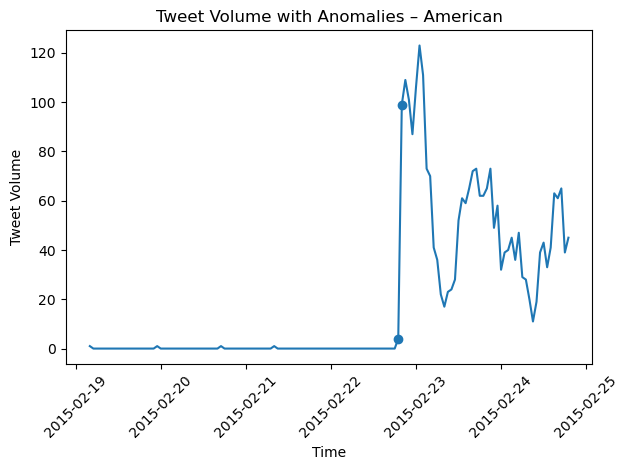

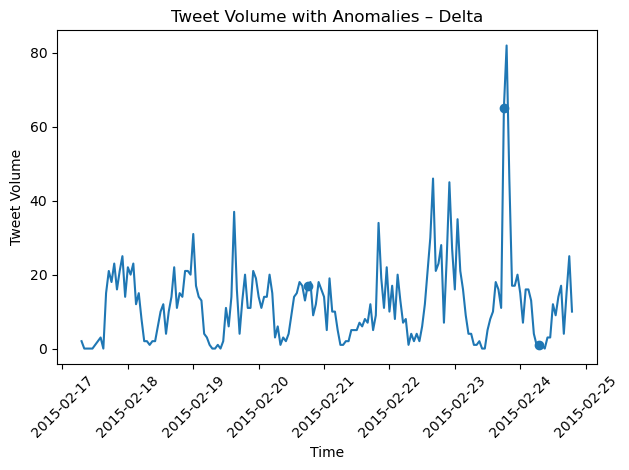

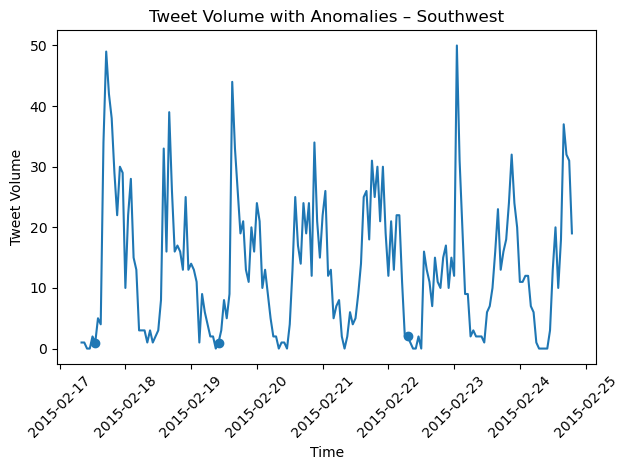

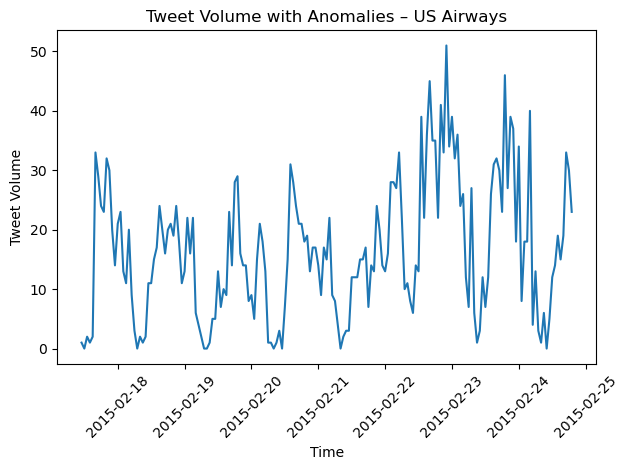

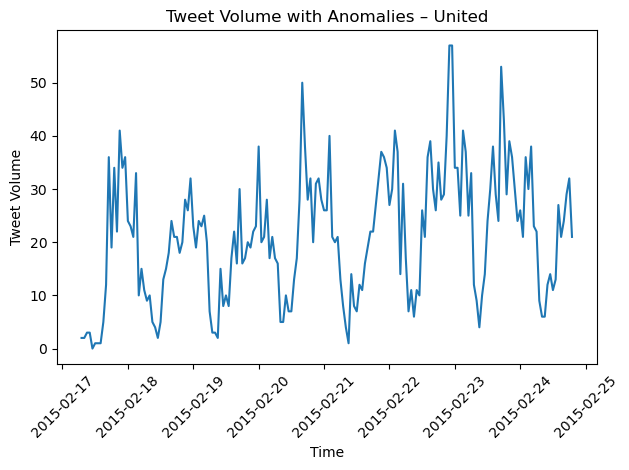

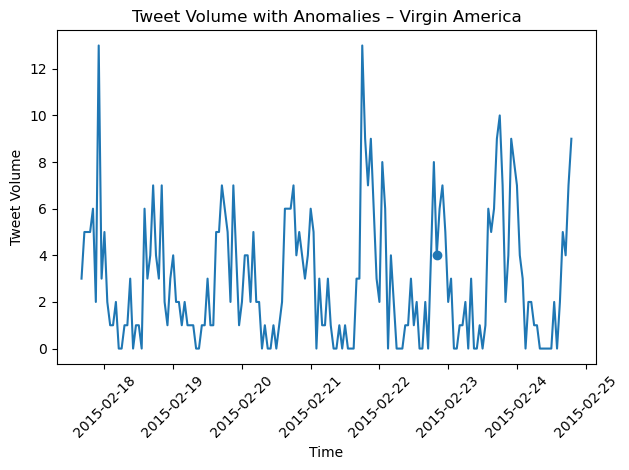

In [60]:
import matplotlib.pyplot as plt

def plot_airline_anomalies(df, airline_name):
    g = df[df["airline"] == airline_name].sort_values("hour_ts")

    plt.figure()
    plt.plot(g["hour_ts"], g["tweet_volume"])
    
    # overlay anomaly points
    anoms = g[g["both_anomaly"] == 1]
    plt.scatter(anoms["hour_ts"], anoms["tweet_volume"])

    plt.title(f"Tweet Volume with Anomalies – {airline_name}")
    plt.xlabel("Time")
    plt.ylabel("Tweet Volume")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# plot for each airline
for airline in features_hourly["airline"].unique():
    plot_airline_anomalies(features_hourly, airline)


In [62]:
# validation rules
features_hourly["validated_crisis_signal"] = (
    (features_hourly["both_anomaly"] == 1) &
    (features_hourly["neg_rate_z"] > 2) &
    (features_hourly["tweet_volume_z"] > 2)
).astype(int)

print("Validated crisis signals:", features_hourly["validated_crisis_signal"].sum())


Validated crisis signals: 2


In [64]:
validated = (
    features_hourly[features_hourly["validated_crisis_signal"] == 1]
    .loc[:, ["airline", "hour_ts", "tweet_volume", "neg_rate",
             "tweet_volume_z", "neg_rate_z"]]
)

validated


,airline,hour_ts,tweet_volume,neg_rate,tweet_volume_z,neg_rate_z
87,American,2015-02-22 19:00:00+00:00,4.0,0.500000,4.694855,4.694855
88,American,2015-02-22 20:00:00+00:00,99.0,0.747475,4.691022,3.867304


In [66]:
# estimate escalation window
features_hourly["crisis_escalation"] = (
    (features_hourly["neg_rate_z"] > 3) &
    (features_hourly["tweet_volume_z"] > 3)
).astype(int)

timing = (
    features_hourly
    .groupby("airline")
    .apply(lambda g: (g["crisis_escalation"].idxmax() - g["validated_crisis_signal"].idxmax())
           if g["validated_crisis_signal"].any() and g["crisis_escalation"].any()
           else np.nan)
)

timing


/var/folders/8m/qndhcbbj3_s26fkzyklnylzw0000gn/T/ipykernel_36835/750981264.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["crisis_escalation"].idxmax() - g["validated_crisis_signal"].idxmax())


airline
American         -50.0
Delta              NaN
Southwest          NaN
US Airways         NaN
United             NaN
Virgin America     NaN
dtype: float64

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Feature columns you used earlier
candidate_features = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]

# Keep only columns that actually exist
feature_cols = [c for c in candidate_features if c in features_hourly.columns]
print("Using features:", feature_cols)

# Create feature matrix
X = features_hourly[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X.shape


NameError: name 'features_hourly' is not defined

In [8]:
import pandas as pd

FEATURE_PATH = "/Users/pavankumar/Downloads/Dataset/anomaly_results_hourly.csv"

features_hourly = pd.read_csv(FEATURE_PATH)

# parse time column (important)
features_hourly["hour_ts"] = pd.to_datetime(features_hourly["hour_ts"], utc=True, errors="coerce")
features_hourly = features_hourly.dropna(subset=["hour_ts"]).copy()

print("Loaded features_hourly:", features_hourly.shape)
features_hourly.head()


Loaded features_hourly: (1027, 27)


,hour_ts,airline,tweet_volume,neg_volume,avg_retweets,avg_conf,hashtag_rate,mention_rate,neg_rate,tweet_volume_roll_mean,...,avg_retweets_z,hashtag_rate_roll_mean,hashtag_rate_roll_std,hashtag_rate_z,neg_rate_diff,if_score,if_anomaly,oc_score,oc_anomaly,both_anomaly
0,2015-02-19 04:00:00+00:00,American,1.0,1.0,0.0,0.924,0.0,1.0,1.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.174005,0,0.163198,0,0
1,2015-02-19 05:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,-1.0,0.092597,0,0.000291,0,0
2,2015-02-19 06:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.171995,0,-0.000280,1,0
3,2015-02-19 07:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.171995,0,-0.000280,1,0
4,2015-02-19 08:00:00+00:00,American,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,0.0,0.0,0.171995,0,-0.000280,1,0


In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance
import pandas as pd

candidate_features = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]

feature_cols = [c for c in candidate_features if c in features_hourly.columns]
print("Using features:", feature_cols)

X = features_hourly[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
iso.fit(X_scaled)

r = permutation_importance(
    iso,
    X_scaled,
    iso.decision_function(X_scaled),
    n_repeats=15,
    random_state=42,
    n_jobs=-1
)

importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)

importance["importance_norm"] = importance["importance"] / importance["importance"].sum()
importance


Using features: ['tweet_volume', 'neg_rate', 'avg_retweets', 'hashtag_rate', 'mention_rate', 'tweet_volume_z', 'neg_rate_z', 'avg_retweets_z', 'hashtag_rate_z', 'neg_rate_diff']


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator IsolationForest(contamination=0.02, n_estimators=300, random_state=42) does not.

In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# baseline model scores
iso_base = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
iso_base.fit(X_scaled)
base_scores = iso_base.decision_function(X_scaled)

imp_list = []

for j, feat in enumerate(feature_cols):
    # drop one feature
    X_drop = X.drop(columns=[feat])
    scaler_drop = StandardScaler()
    X_drop_scaled = scaler_drop.fit_transform(X_drop)

    iso_drop = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
    iso_drop.fit(X_drop_scaled)
    drop_scores = iso_drop.decision_function(X_drop_scaled)

    # impact = how much scores shift (bigger shift => more important)
    impact = np.mean(np.abs(base_scores - drop_scores))
    imp_list.append((feat, impact))

drop_importance = pd.DataFrame(imp_list, columns=["feature", "drop_score_impact"]) \
                    .sort_values("drop_score_impact", ascending=False)

drop_importance["impact_norm"] = drop_importance["drop_score_impact"] / drop_importance["drop_score_impact"].sum()
drop_importance


,feature,drop_score_impact,impact_norm
9,neg_rate_diff,0.023525,0.168112
4,mention_rate,0.019893,0.142152
1,neg_rate,0.018601,0.132922
6,neg_rate_z,0.016381,0.117058
3,hashtag_rate,0.011830,0.084539
5,tweet_volume_z,0.011261,0.080473
8,hashtag_rate_z,0.011039,0.078882
7,avg_retweets_z,0.009734,0.069560
0,tweet_volume,0.008943,0.063905
2,avg_retweets,0.008732,0.062396


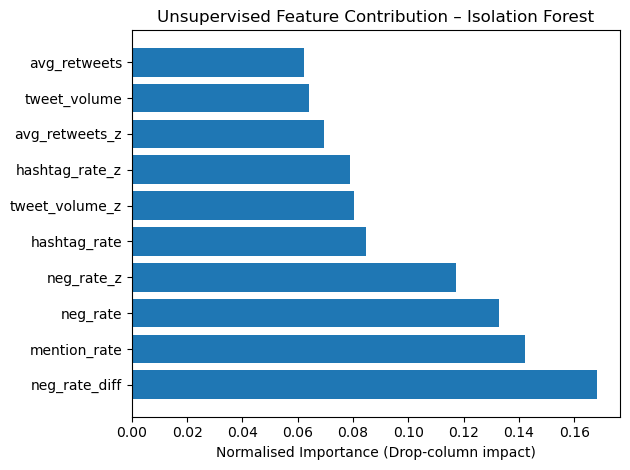

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(drop_importance["feature"], drop_importance["impact_norm"])
plt.xlabel("Normalised Importance (Drop-column impact)")
plt.title("Unsupervised Feature Contribution – Isolation Forest")
plt.tight_layout()
plt.show()


In [18]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)

iso.fit(X_scaled)


IsolationForest(contamination=0.02, n_estimators=300, random_state=42)

In [24]:
import os

HOME = os.path.expanduser("~")
PROJECT_DIR = os.path.join(HOME, "airline_anomaly_project")

os.makedirs(PROJECT_DIR, exist_ok=True)

OUT_PATH = os.path.join(PROJECT_DIR, "tweets_cleaned.csv")
df.to_csv(OUT_PATH, index=False)

print("Saved to:", OUT_PATH)


NameError: name 'df' is not defined

In [26]:
import pandas as pd

CLEANED_PATH = "/Users/pavankumar/Downloads/Dataset/tweets_cleaned.csv"
df = pd.read_csv(CLEANED_PATH)

print(df.shape)
df.head()


(14485, 23)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negative_reason,negative_reason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,tweet_location,tweet_timezone,hour,dayofweek,date,tweet_text_clean,hashtags,mentions,hashtag_count,mention_count
0,568265091226800130,negative,0.9240,Late Flight,0.4904,American,negative,beaubertke,Late Flight,0,...,Texas,Central Time (US & Canada),4,3,2015-02-19,okay i think 1565 has waited long enough for a...,[],['americanair'],0,1
1,568551906634797056,positive,0.6242,NaN,0.0000,American,positive,byunsamuel,NaN,0,...,"Sunnyside, NY",Eastern Time (US & Canada),23,3,2015-02-19,hopefully you ll see bad ones as opportunity t...,[],['americanair'],0,1
2,568824537338417154,negative,1.0000,Customer Service Issue,0.6727,American,negative,KaiserSnowse,Customer Service Issue,0,...,NaN,Central Time (US & Canada),17,4,2015-02-20,how long does it take to get credit to my aa a...,[],['americanair'],0,1
3,569047438880841728,negative,1.0000,Lost Luggage,0.5345,American,negative,ohmal,Customer Service Issue\nLost Luggage,0,...,NaN,London,8,5,2015-02-21,you need to work harder on the disconnect betw...,[],['americanair'],0,1
4,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,...,"dallas, TX",NaN,19,6,2015-02-22,we have 8 ppl so we need 2 know how many seats...,[],['americanair'],0,1


In [28]:
import os

HOME = os.path.expanduser("~")
PROJECT_DIR = os.path.join(HOME, "airline_anomaly_project")
os.makedirs(PROJECT_DIR, exist_ok=True)

OUT_PATH = os.path.join(PROJECT_DIR, "tweets_cleaned.csv")
df.to_csv(OUT_PATH, index=False)

print("Saved to:", OUT_PATH)


Saved to: /Users/pavankumar/airline_anomaly_project/tweets_cleaned.csv


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


In [36]:
feature_cols = [
    "tweet_volume",
    "neg_rate",
    "avg_retweets",
    "hashtag_rate",
    "mention_rate",
    "tweet_volume_z",
    "neg_rate_z",
    "avg_retweets_z",
    "hashtag_rate_z",
    "neg_rate_diff",
]


In [38]:
anomaly_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("isolation_forest", IsolationForest(
            n_estimators=300,
            contamination=0.02,
            random_state=42
        ))
    ]
)


In [40]:
X = features_hourly[feature_cols].fillna(0)
anomaly_pipeline.fit(X)


Pipeline(steps=[('scaler', StandardScaler()),
                ('isolation_forest',
                 IsolationForest(contamination=0.02, n_estimators=300,
                                 random_state=42))])

In [42]:
from sklearn import set_config
set_config(display="diagram")

anomaly_pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('isolation_forest',
                 IsolationForest(contamination=0.02, n_estimators=300,
                                 random_state=42))])

In [44]:
from sklearn.svm import OneClassSVM

if_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("isolation_forest", IsolationForest(
            n_estimators=300,
            contamination=0.02,
            random_state=42
        ))
    ]
)

oc_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("ocsvm", OneClassSVM(
            kernel="rbf",
            nu=0.02,
            gamma="scale"
        ))
    ]
)


In [46]:
set_config(display="diagram")
if_pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('isolation_forest',
                 IsolationForest(contamination=0.02, n_estimators=300,
                                 random_state=42))])

In [48]:
oc_pipeline


Pipeline(steps=[('scaler', StandardScaler()), ('ocsvm', OneClassSVM(nu=0.02))])